In [166]:
import numpy as np
import seaborn as sns
from joblib import dump, load
import pandas as pd
import matplotlib.pyplot as plt

In [167]:
models = {
    "RoBERTa Large MNLI": {
        "CB": {
            "paths": [
                "CB_14080833_a92bc1",
                "CB_12091040_1553f6",
                "CB_14090817_6ff483"
            ],
            "y_lim": (0.8, 0.99)
        }
            ,
        "RTE": {
            "paths": [
                "RTE_14080853_7b3e49",
                "RTE_12091146_18d51d",
                "RTE_14090840_987235"
            ],
            "y_lim": (0.82, 0.93)
        },
        "CNLI": {
            "paths": [
                "CNLI_14081645_f78891",
                "CNLI_13091920_602d8c",
                "CNLI_14091938_623a32"
            ],
            "y_lim": (0.7, 0.9)
        }
    },
    "DistilRoBERTa Base": {
        "CB": {
            "paths": [
                "CB_07092027_ea8a85",
                "CB_12091102_e64922",
                "CB_13092220_4313ab"
            ],
            "y_lim": (0.5, 0.75)
        },
        "RTE": {
            "paths": [
                "RTE_07092037_a71b2b",
                "RTE_12091258_886eb3",
                "RTE_13092228_0b4f67"
            ],
            "y_lim": (0.45, 0.7)
        },
        "CNLI": {
            "paths": [
                "CNLI_07092107_5281d2",
                "CNLI_12091957_c9f0f3",
                "CNLI_13092115_495854"
            ],
            "y_lim": (0.4, 0.66)
        }
    }
}

In [168]:
def get_model_scoring_data(path, boosting_round):
    loaded_tree_model_result = load(f"logs/{path}/result.joblib")

    scores = np.zeros((11, 3))

    best_scores = [
        ["FreeGBDT", -999],
        ["Regular Tree", -999],
        ["MLP", -999]
    ]

    for i, epoch_result in enumerate(loaded_tree_model_result["tree_scores"]):
        scores[i, 0] = epoch_result[boosting_round]
        best_scores[0][1] = max(best_scores[0][1], epoch_result[boosting_round])


    for i, epoch_result in enumerate(loaded_tree_model_result["regular_tree_scores"]):
        scores[i, 1] = epoch_result[boosting_round]
        best_scores[1][1] = max(best_scores[1][1], epoch_result[boosting_round])

    for i, epoch_result in enumerate(loaded_tree_model_result["nn_scores"]):
        scores[i, 2] = epoch_result
        best_scores[2][1] = max(best_scores[2][1], epoch_result)

    scores = np.delete(scores, (10), axis=0)

    return scores, best_scores


In [169]:
def visualize_model_scoring_data(scores, best_scores, title, y_lim):
    score_df = pd.DataFrame(scores, columns=["FreeGBDT", "Regular Tree", "MLP"])
    fig, ax = plt.subplots(figsize=(11,5))

    scores_text = f"{best_scores[0][0]}: {best_scores[0][1]:.3f} | " \
                  f"{best_scores[1][0]}: {best_scores[1][1]:.3f} | " \
                  f"{best_scores[2][0]}: {best_scores[2][1]:.3f}"

    chart_title = f"{title}\n{scores_text}"

    fig.suptitle(chart_title, fontsize=15)
    display(sns.lineplot(score_df, ax=ax, linewidth=3))
    ax.set_ylim(y_lim)
    fig.savefig(f"analysis/{title}.png")

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

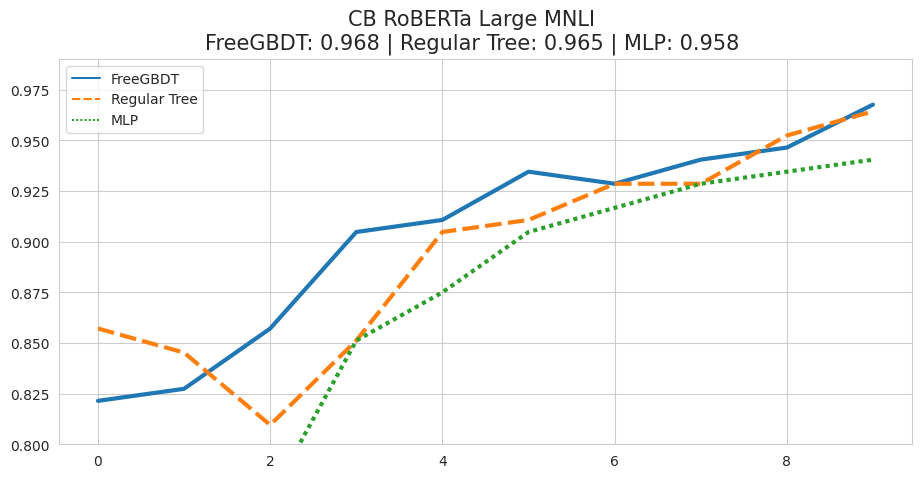

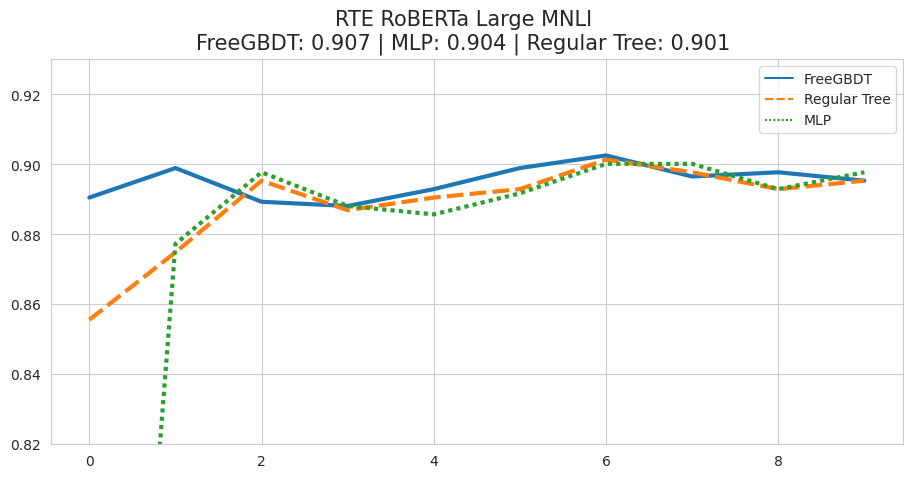

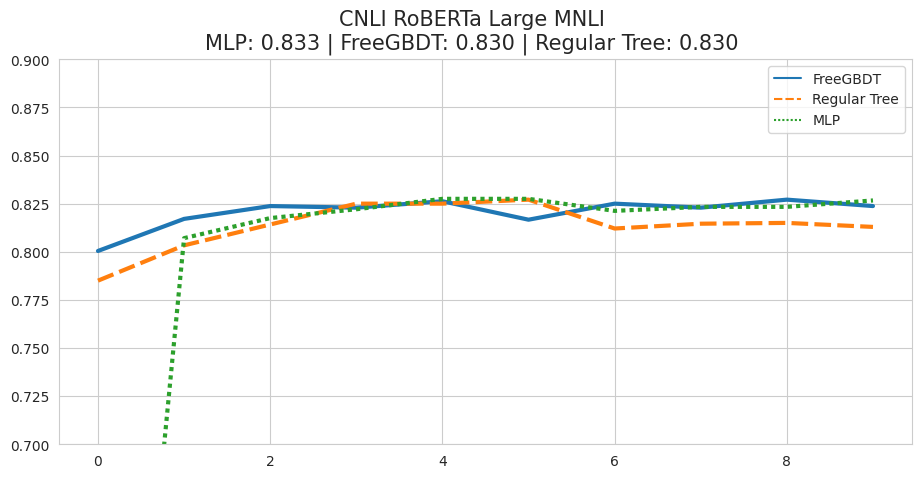

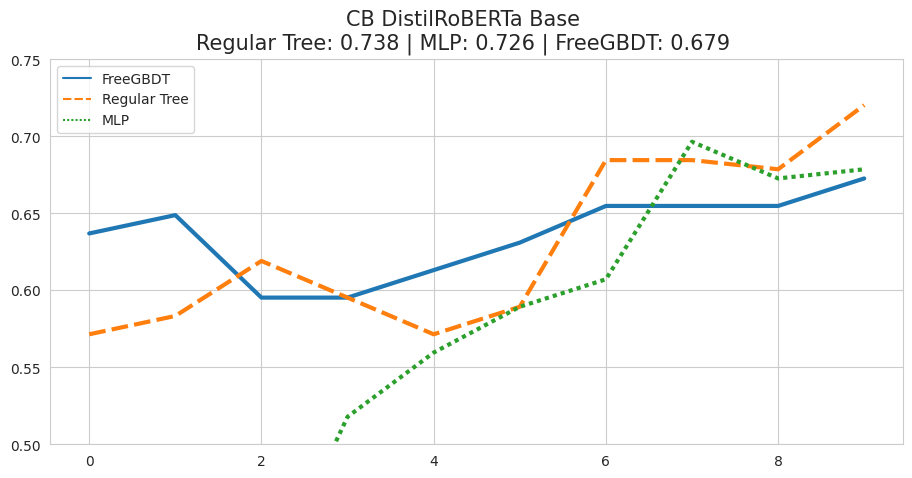

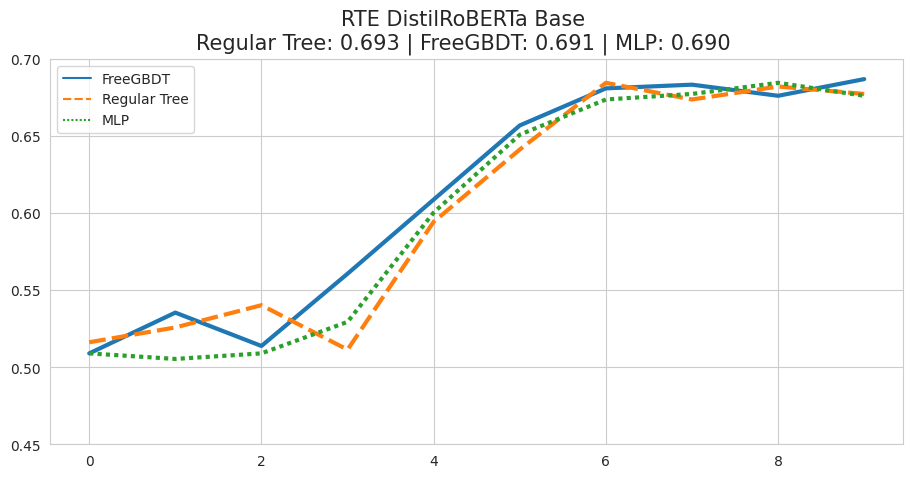

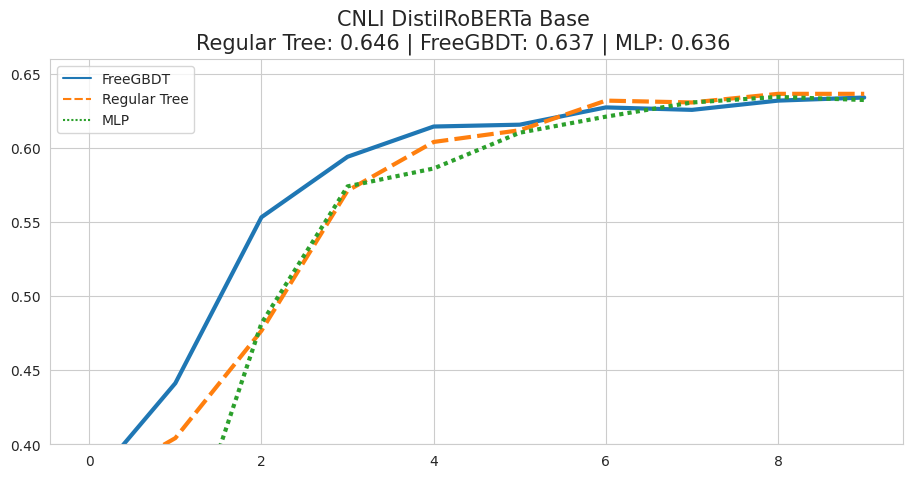

In [170]:
model_data_combinations = [
    ("RoBERTa Large MNLI", "CB"),
    ("RoBERTa Large MNLI", "RTE"),
    ("RoBERTa Large MNLI", "CNLI"),
    ("DistilRoBERTa Base", "CB"),
    ("DistilRoBERTa Base", "RTE"),
    ("DistilRoBERTa Base", "CNLI"),
]

for model, dataset in model_data_combinations:
    scores = np.zeros((10, 3))
    best_scores = [
        ["FreeGBDT", 0],
        ["Regular Tree", 0],
        ["MLP", 0]
    ]

    for path in models[model][dataset]["paths"]:
        scores_temp, best_scores_temp = get_model_scoring_data(path, 1)

        scores += scores_temp
        best_scores[0][1] += best_scores_temp[0][1]
        best_scores[1][1] += best_scores_temp[1][1]
        best_scores[2][1] += best_scores_temp[2][1]


    scores /= 3
    best_scores[0][1] /= 3
    best_scores[1][1] /= 3
    best_scores[2][1] /= 3

    best_scores = sorted(best_scores, key=lambda x: x[1], reverse=True)

    y_lim = models[model][dataset]["y_lim"]

    visualize_model_scoring_data(scores, best_scores, f"{dataset} {model}", y_lim)